## 6.1. plotting signatures of cell death in pseudotime

In this Notebook we are plotting two cell death signatures (pyroptosis and necroptosis) in different ways. We take a look at the expression of these signatures in pseudotime, but we also use dotplots to have a look at how the individual genes are changing in experimental time. 

The gene lists that we are using were retrieved from the Mouse Genome Database (MGD), Mouse Genome Informatics, The Jackson Laboratory, Bar Harbor, Maine. World Wide Web (URL: http://www.informatics.jax.org). You can have a look at the website, or you can use the file on our Github repository (`/data/gene_lists/cell_death_marker_genes.csv`).

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd
import copy

# single cell libraries
import scanpy as sc
sc.settings.verbosity = 0 

# other 
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization

# import own functions
from plotting import *
from utils import *

# autoreload
%load_ext autoreload
%autoreload 2

### Load data and pseudotime

Here, we load the preprocessed HSPC dataset (as filtered in notebook 1.3).

In [2]:
### load Anndata object with the HSPC dataset (all four subsets incl.)
adata_path = "../data/count_matrices/all_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

In [3]:
### load pseudotime 
pseudotime_path = "../results/pseudotime/pseudotime_all_cells.csv"
pseudotime = pd.read_csv(pseudotime_path, sep=",", index_col=0)

In [4]:
### add pseudotime to dataset
adata.obs["pseudotime"] = pseudotime

In [5]:
### ad pseudotemporal ordering to the dataset
adata.obs["pt_ordering"] = np.argsort(np.argsort(adata.obs["pseudotime"]))

In [6]:
### get timepoints and clusters
timepoints = adata.obs["time"].cat.categories.values
clusters = adata.obs['clusters'].cat.categories.values

In [7]:
### load marker genes
marker_genes_path = "../data/gene_lists/cell_death_marker_genes.csv"
marker_genes = pd.read_csv(marker_genes_path, sep=";")

### Processing

In [8]:
### L2 normalize dataset
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')

In [9]:
### scale dataset
scaled_adata = copy.deepcopy(adata)
sc.pp.scale(scaled_adata)

In [10]:
adata.X = adata.X.todense()

### Create plots
Here we are creating different plots that visualize individual genes (such as the pro-survival genes Bcl2, Birc2 and Birc5), visualize gene signatures (necroptosis and pyroptosis) for different cluster groups, and visualize the expression of individual genes (dotplot). These figures can be found back in figure 6 and extended figure 5 of our publication. 

PS: we wrote the function `plot_in_pseudotime` to plot all types of signatures and genes in pseudotime. Have a look in `plotting.py` to get a better idea of what the function is actually doing.

In [11]:
prosurvival_genes = ['Bcl2', 'Birc2', 'Birc5']

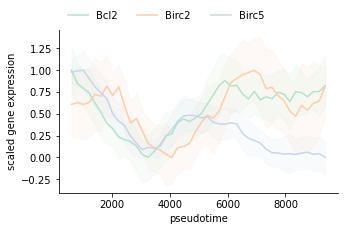

In [12]:
### plot prosurvival genes in PT
plot_in_pseudotime(
    adata, 
    prosurvival_genes, 
    plot_all_clusters=True, 
    smoothing_window_size=600, 
    scale=True, 
    legend_location='top',
    save=True,
    save_path="../figures/6.1.PT_plot_prosurvival_genes.pdf")

In [13]:
necroptosis_markers = marker_genes['necroptosis'].dropna().values
pyroptosis_markers = marker_genes['pyroptosis'].dropna().values

In [14]:
sc.tl.score_genes(scaled_adata, necroptosis_markers, score_name="necroptosis")
sc.tl.score_genes(scaled_adata, pyroptosis_markers, score_name="pyroptosis")

In [15]:
celltypes = {
    'HSCs':['HSCs #1', 'HSCs #2'],
    'LMPPs':['LMPPs #1', 'LMPPs #2'],
    'erythroid':['ery. prog. #1','ery. prog. #2', 'ery. prog. #3'],
    'myeloid':['myel. prog. #1', 'myel. prog. #2', 'myel. prog. #3',]}

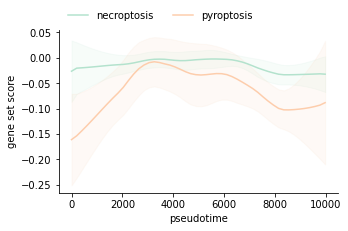

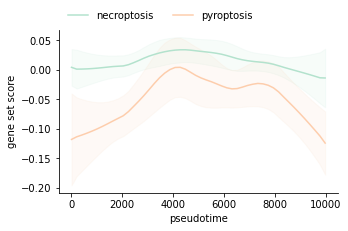

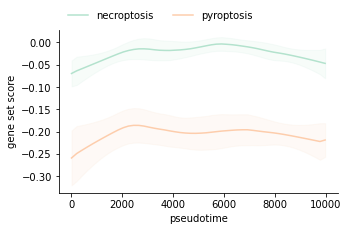

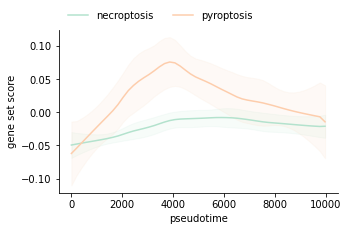

In [16]:
### plot necroptosis and pyroptosis in different celltypes (multiple clusters)
for key in celltypes:
    celltype_mask = scaled_adata.obs['clusters'].isin(celltypes[key])
    
    plot_in_pseudotime(
        scaled_adata[celltype_mask], 
        ['necroptosis', 'pyroptosis'], 
        plot_all_clusters=True, 
        smoothing_window_size=300, 
        scale=False, 
        legend_location='top',
        save=True,
        save_path=f"../figures/6.1.PT_plot_necroptosis_pyroptosis_{key}.pdf")

In [17]:
selected_genes = ['Casp1', 'Casp4']

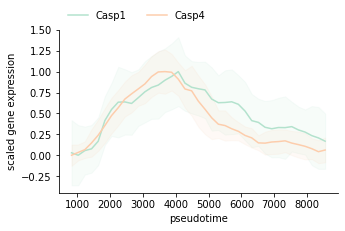

In [18]:
### plot expression of Casp1 and Casp4 (typical pyroptosis genes) in PT
myeloid_clusters = ['myel. prog. #1', 'myel. prog. #2', 'myel. prog. #3',]
myeloid_mask = scaled_adata.obs['clusters'].isin(myeloid_clusters)

plot_in_pseudotime(
    adata[myeloid_mask], 
    selected_genes, 
    plot_all_clusters=True, 
    smoothing_window_size=300, 
    scale=True, 
    legend_location='top',
    save=True,
    save_path="../figures/6.1.PT_plot_casp1_casp4.pdf")

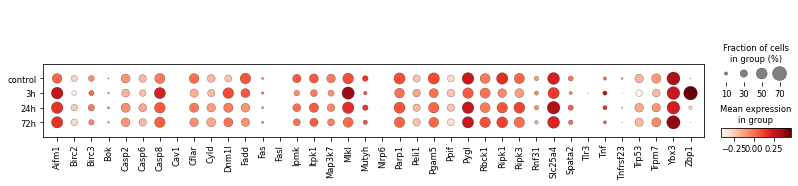

In [19]:
### plot expression of necroptosis genes in dotplot
fig, axs = plt.subplots(
    1, 1, figsize=(len(necroptosis_markers)*0.3 + 2,2.4))

sc.pl.dotplot(
    scaled_adata[myeloid_mask],
    var_names=necroptosis_markers,
    groupby="time", 
    standard_scale=None,
    show=False,
    ax=axs
)

save_path = "../figures/6.1.dotplot_necroptosis_markers.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

plt.show()

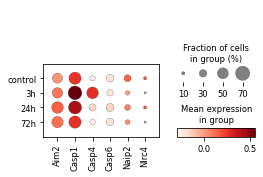

In [20]:
### plot expression of pyroptosis genes in dotplot
fig, axs = plt.subplots(
    1, 1, figsize=(len(pyroptosis_markers)*0.3 + 2 ,2.4))

sc.pl.dotplot(
    scaled_adata[myeloid_mask],
    var_names=pyroptosis_markers,
    groupby="time", 
    standard_scale=None,
    show=False,
    ax=axs
)

save_path = "../figures/6.1.dotplot_pyroptosis_markers.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

plt.show()

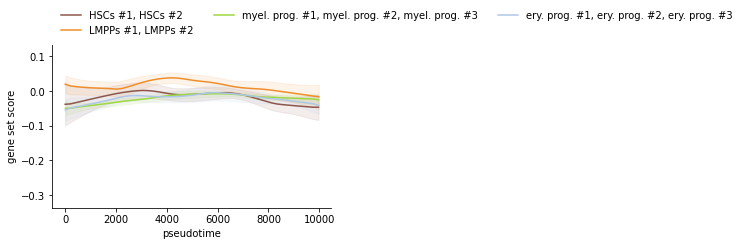

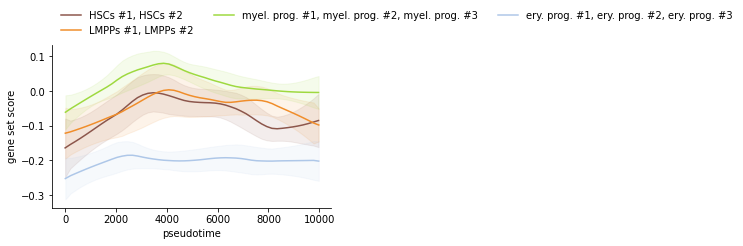

In [22]:
### plot necroptosis and pyroptosis in different celltypes (multiple clusters) in one figure
for item in ['necroptosis', 'pyroptosis']:
    plot_in_pseudotime(
        scaled_adata, 
        items=[item],
        clusters=[
            ['HSCs #1', 'HSCs #2'], 
            ['LMPPs #1', 'LMPPs #2'], 
            ['myel. prog. #1','myel. prog. #2', 'myel. prog. #3'], 
            ['ery. prog. #1', 'ery. prog. #2','ery. prog. #3'],
        ],
        smoothing_window_size=300, 
        scale=False,
        legend_location="top",
        ymin=-0.3365964745288863,
        ymax=0.13345676637804896,
        save=True,
        save_path=f"../figures/6.1.PT_plot_{item}_merged_clusters.pdf")

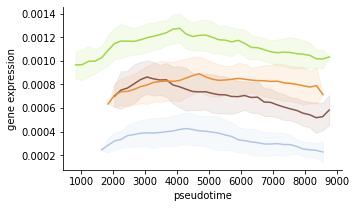

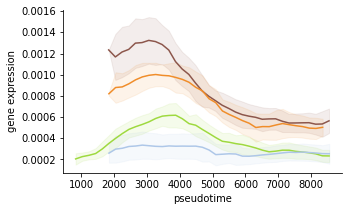

In [23]:
### plot expression of Casp1 and Casp4 in different celltypes (multiple clusters) in one figure
for gene in ['Casp1', 'Casp4']:
    plot_in_pseudotime(
        adata, 
        items=[gene],
        clusters=[
            ['HSCs #1', 'HSCs #2'], 
            ['LMPPs #1', 'LMPPs #2'], 
            ['myel. prog. #1','myel. prog. #2', 'myel. prog. #3'], 
            ['ery. prog. #1', 'ery. prog. #2','ery. prog. #3'],
        ],
        smoothing_window_size=300, 
        scale=False,
        legend_location=None,
        save=True,
        save_path=f"../figures/6.1.PT_plot_{gene}_merged_clusters.pdf")